# Recitation: Cross_Val_Score, Grid Search, ROC and Precision Recall Curves

Author: Sachin K Sunny (ssunny [at symbol] andrew.cmu.edu)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torchvision
import torchvision.transforms as transforms

import warnings
warnings.filterwarnings('ignore')

np.random.seed(0)

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]  =  "TRUE"

## Data preparation

In [4]:
train_dataset = torchvision.datasets.MNIST(root='data/',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

9913344it [00:03, 2592627.73it/s]                             


Extracting data/MNIST\raw\train-images-idx3-ubyte.gz to data/MNIST\raw



29696it [00:00, 8361015.75it/s]          


Extracting data/MNIST\raw\train-labels-idx1-ubyte.gz to data/MNIST\raw



1649664it [00:02, 799714.32it/s]                              


Extracting data/MNIST\raw\t10k-images-idx3-ubyte.gz to data/MNIST\raw



5120it [00:00, 5131382.67it/s]          

Extracting data/MNIST\raw\t10k-labels-idx1-ubyte.gz to data/MNIST\raw



In [5]:
train_images = np.array([image.numpy() for image, label in train_dataset])

In [6]:
train_labels = np.array([label for image, label in train_dataset])

In [7]:
train_images.shape

(60000, 1, 28, 28)

In [8]:
train_labels

array([5, 0, 4, ..., 5, 6, 8])

In [9]:
train_images.shape

(60000, 1, 28, 28)

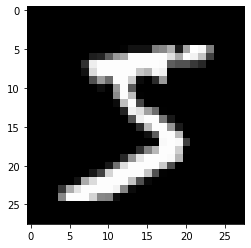

In [10]:
plt.imshow(train_images[0][0], cmap='gray')

In [11]:
train_images = train_images[:2000]
train_labels = train_labels[:2000]

In [12]:
train_images_flat = train_images.reshape(len(train_images), -1)  # flattens out each training image

In [13]:
print(train_images_flat.shape)

(2000, 784)


## Choosing hyperparameter $k$ using cross_val_score

In [14]:
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

highest_cross_val_accuracy = -np.inf
for k in 2**np.arange(0, 8):
    classifier = KNeighborsClassifier(n_neighbors=k)
    
    scores = cross_val_score(classifier, train_images_flat, train_labels, scoring = 'accuracy', cv = 5)
        
    cross_val_accuracy = scores.mean()
    print('k:', k, 'cross validation accuracy:', cross_val_accuracy)
    
    if cross_val_accuracy > highest_cross_val_accuracy:
        highest_cross_val_accuracy = cross_val_accuracy
        best_k = k

print('Best k:', best_k, 'cross validation accuracy:', highest_cross_val_accuracy)

k: 1 cross validation accuracy: 0.8939999999999999
k: 2 cross validation accuracy: 0.876
k: 4 cross validation accuracy: 0.891
k: 8 cross validation accuracy: 0.8835
k: 16 cross validation accuracy: 0.8594999999999999
k: 32 cross validation accuracy: 0.8380000000000001
k: 64 cross validation accuracy: 0.7935
k: 128 cross validation accuracy: 0.7184999999999999
Best k: 1 cross validation accuracy: 0.8939999999999999


## Using Random Forest classifiers and Grid Search

Next, we see cross-validation for random forests. Importantly, now we sweep over two hyperparameters.

In [15]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

num_features = train_images_flat.shape[1]
max_features= [int(np.ceil(np.sqrt(num_features) / 4)),int(np.ceil(np.sqrt(num_features))),\
                int(np.ceil(np.sqrt(num_features) * 4))]
min_samples_leaf = [1, 2, 4, 8, 16]

params = {'max_features': max_features, 'min_samples_leaf': min_samples_leaf} #hyperparameters to loop over

classifier = RandomForestClassifier()

gridsearch = GridSearchCV(classifier, params, cv=5) #create the grid search object

gridsearch.fit(train_images_flat, train_labels) #run the grid search for each hyperparemeter configuration

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_features': [7, 28, 112],
                         'min_samples_leaf': [1, 2, 4, 8, 16]})

In [17]:
gridsearch.cv_results_['mean_test_score']

array([0.8965, 0.898 , 0.8845, 0.8655, 0.838 , 0.911 , 0.904 , 0.8915,
       0.876 , 0.8535, 0.9075, 0.907 , 0.8915, 0.885 , 0.846 ])

In [18]:
np.argmax(gridsearch.cv_results_['mean_test_score'])

5

In [19]:
#which configuration gave the best results?
gridsearch.cv_results_['params'][np.argmax(gridsearch.cv_results_['mean_test_score'])]

{'max_features': 28, 'min_samples_leaf': 1}

# ROC curve

- [ROC curves](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) are a way to evaluate classifiers
- There is an inherent tradeoff between true positives and false positives


More on the scikit-learn ROC curve module [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)

In [20]:
#Load Data 
from sklearn import datasets
iris = datasets.load_iris()
Xi = iris.data
yi = iris.target
Xi, yi = Xi[yi != 2], yi[yi != 2]
n_samples, n_features = Xi.shape

In [22]:
type(iris)

sklearn.utils.Bunch

In [27]:
n_features

4

In [23]:
Xi

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

In [24]:
# Add noisy features
random_state = np.random.RandomState(0)
Xi = np.c_[Xi, random_state.randn(n_samples, 200 * n_features)] #concatenates new features

In [26]:
Xi.shape

(100, 804)

In [28]:
#Hold Out Test Data
from sklearn.model_selection import train_test_split
Xi_train, Xi_test, yi_train, yi_test = train_test_split(Xi, yi, test_size=0.25, shuffle=True)

In [29]:
from sklearn.metrics import roc_curve
clf_rf = RandomForestClassifier(n_estimators=100)
clf_rf.fit(Xi_train, yi_train)
y_score = clf_rf.predict_proba(Xi_test)[:,1] #probabilistic classifier, so the model outputs probabilities

array([0.51, 0.39, 0.67, 0.4 , 0.71, 0.66, 0.66, 0.68, 0.47, 0.45, 0.7 ,
       0.56, 0.61, 0.36, 0.47, 0.45, 0.4 , 0.45, 0.39, 0.64, 0.41, 0.4 ,
       0.39, 0.7 , 0.43])

In [35]:
np.unique(yi_test.reshape(1,-1))

array([0, 1])

In [30]:
clf_rf.predict_proba(Xi_test)

array([[0.49, 0.51],
       [0.61, 0.39],
       [0.33, 0.67],
       [0.6 , 0.4 ],
       [0.29, 0.71],
       [0.34, 0.66],
       [0.34, 0.66],
       [0.32, 0.68],
       [0.53, 0.47],
       [0.55, 0.45],
       [0.3 , 0.7 ],
       [0.44, 0.56],
       [0.39, 0.61],
       [0.64, 0.36],
       [0.53, 0.47],
       [0.55, 0.45],
       [0.6 , 0.4 ],
       [0.55, 0.45],
       [0.61, 0.39],
       [0.36, 0.64],
       [0.59, 0.41],
       [0.6 , 0.4 ],
       [0.61, 0.39],
       [0.3 , 0.7 ],
       [0.57, 0.43]])

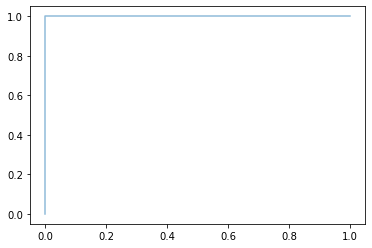

In [36]:
fpr, tpr, thresholds = roc_curve(yi_test, y_score, pos_label=1)
auc = np.trapz(tpr, fpr)
plt.plot(fpr, tpr, linestyle='-', alpha=0.5, color= "C0", label = 100)

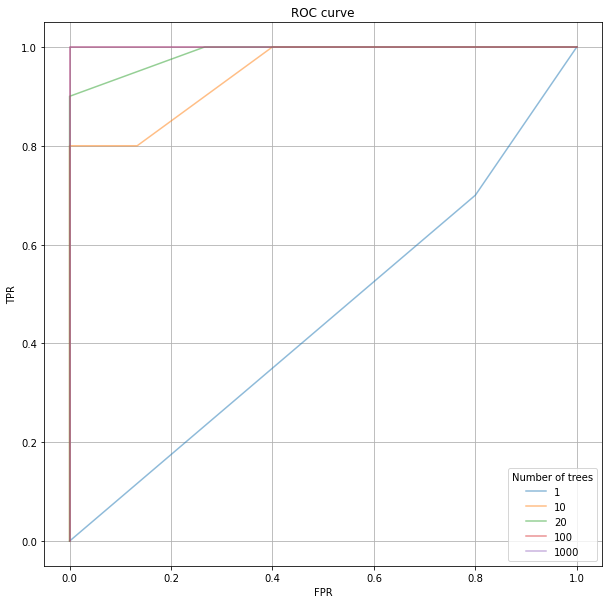

In [37]:
from sklearn.metrics import roc_curve

# Random Forests
ntrees= [1, 10, 20, 100, 1000]
colors = ["C0", "C1", 'C2','C3', 'C4']

plt.figure(figsize=(10,10))
for i in range(len(ntrees)):
    clf_rf = RandomForestClassifier(n_estimators=ntrees[i])
    clf_rf.fit(Xi_train, yi_train)
    y_score = clf_rf.predict_proba(Xi_test)[:,1] #probabilistic classifier, so the model outputs probabilities
    fpr, tpr, thresholds = roc_curve(yi_test, y_score, pos_label=1)
    auc = np.trapz(tpr, fpr)
    plt.plot(fpr, tpr, linestyle='-', alpha=0.5, color= colors[i], label = ntrees[i])

plt.title("ROC curve")
plt.legend(title = "Number of trees", loc = "best")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.grid()
plt.show() 

# Predicting Diabetes Cases

The National Institute of Diabetes and Digestive and Kidney Diseases has collected the Pima Indians dataset, which contains data from clinical exams for women age 21 and above of Pima Indian origins. In this problem, we predict whether each woman has diabetes or not based on diagnostic measurements.

For each woman, the following features were recorded:
- Pregnancies: Number of times pregnant
- Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
- Blood Pressure: Diastolic blood pressure (mm Hg)
- Skin Thickness: Triceps skin fold thickness (mm)
- Insulin: 2-Hour serum insulin (mu U/ml)
- BMI: Body mass index (weight in kg/(height in m)^2)
- Diabetes Pedigree Function: Diabetes pedigree function
- Age: Age (years)

Per woman, the label is binary (1=diabetic, 0=not diabetic).

We begin by loading in the data:

In [38]:
diabetes_X_train = np.loadtxt('diabetes_X_train.txt')
diabetes_y_train = np.loadtxt('diabetes_y_train.txt')
diabetes_X_test = np.loadtxt('diabetes_X_test.txt')
diabetes_y_test = np.loadtxt('diabetes_y_test.txt')
diabetes_features = ['Pregnancies',
                     'Glucose',
                     'Blood Pressure',
                     'Skin Thickness',
                     'Insulin',
                     'BMI',
                     'Diabetes Pedigree Function',
                     'Age']
print(diabetes_X_train.shape, diabetes_y_train.shape)
print(diabetes_X_test.shape, diabetes_y_test.shape)

(576, 8) (576,)
(192, 8) (192,)


## Staring at Data

Explore the training data by drawing a histogram for each feature.

In [39]:
for idx in range(diabetes_X_train.shape[1]):
    print(idx)

0
1
2
3
4
5
6
7


In [41]:
type(diabetes_X_train)

numpy.ndarray

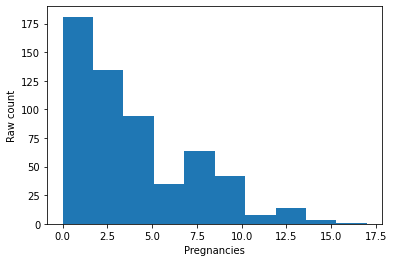

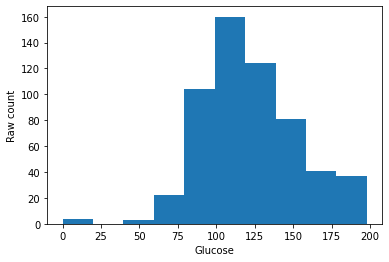

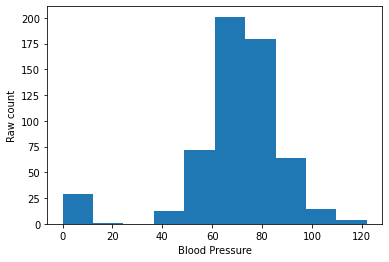

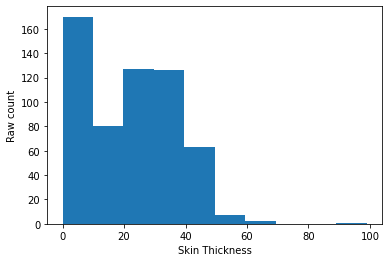

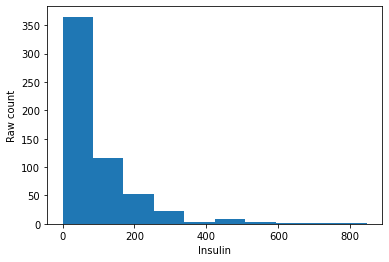

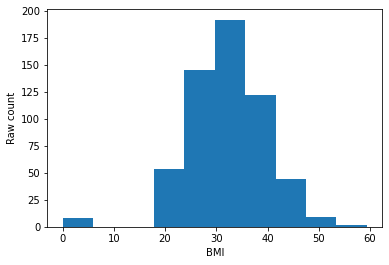

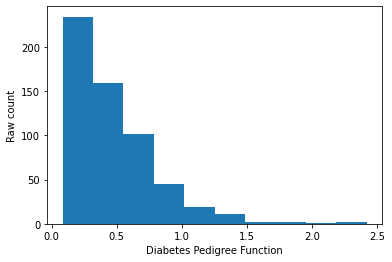

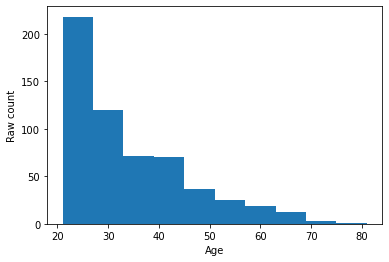

In [42]:
# ------------------------------------------------------------------------------
# TODO: WRITE YOUR CODE HERE
#

for idx in range(diabetes_X_train.shape[1]):
    plt.hist(diabetes_X_train[:, idx])
    plt.xlabel(diabetes_features[idx])
    plt.ylabel('Raw count')
    plt.show()

#
# END OF YOUR CODE
# ------------------------------------------------------------------------------

### Question:
Clearly explain why the features should be standardized.

#### SOLUTION - 
The feature values have scales that are drastically different by orders of magnitude (for instance, compare insulin with diabetes pedigree function). Standardizing (by subtracting the mean and dividing by the standard deviation) would prevent the feature with the largest scale from dominating the analysis.

### Question: 
Suppose that we are standardizing the data (by subtracting off each feature's mean and dividing by its standard deviation) and also doing cross-validation. Explain why standardization should *not* be applied to the full training dataset first before running cross-validation. When should standardization be run?

#### SOLUTION - 
Standardization should be applied within each cross-validation fold's training data and not across the full training dataset first. Each fold of cross-validation is meant to mimic what the actual setup is like during test time. In particular, if we were to standardize across the entire training dataset first, and then hide part of it to use as a validation set, we have contaminated our training data with validation data! Specifically, we have used each fold's validation data's values in standardizing features within the same fold's training data! Instead, within each cross-validation fold, we standardize based on that fold's training data's feature vectors.

### Model Selection
We shall use 5-fold cross-validation but with a twist! For each fold, compute two different scores: precision and recall (separately and not the F1 score). Use a random forest classifier, sweeping over 4 different `n_estimators` values (50, 100, 150, 200) and 6 `max_depth` values (2, 3, 4, 5, 6, 7), i.e., sweep over a total of 4x6=24 hyperparameter settings. For the `RandomForestClassifier`, aside from `n_estimators` and `max_depth`, only specify one additional setting `random_state=95865`.

In [50]:
from sklearn.preprocessing import StandardScaler

# WARNING: YOU SHOULD ONLY HAVE TO WRITE CODE IN THE PART BELOW THAT SAYS "TODO"
kf = KFold(n_splits=5, random_state=95865, shuffle=True)

fold_precision_scores = []
fold_recall_scores = []
i=0
for train_indices, val_indices in kf.split(diabetes_X_train):
    fold_X_train = diabetes_X_train[train_indices]
    fold_y_train = diabetes_y_train[train_indices]
    fold_X_val = diabetes_X_train[val_indices]
    fold_y_val = diabetes_y_train[val_indices]
        
    fold_scaler = StandardScaler()
    fold_X_train_standardized = fold_scaler.fit_transform(fold_X_train)
    fold_classifier = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=95865)
    fold_classifier.fit(fold_X_train_standardized, fold_y_train)
    fold_y_val_predicted = fold_classifier.predict(fold_scaler.transform(fold_X_val))
        
    fold_true_pred_mask = (fold_y_val_predicted == 1)
    if fold_true_pred_mask.sum() > 0:
        fold_precision = (fold_y_val[fold_true_pred_mask] == 1).mean()  #for those predicted as 1, count how many are actual 1, and sum the count and divided by all 
    else:
        # corner case to avoid division by 0
        fold_precision = 0.
    
    fold_recall_mask = (fold_y_val == 1)
    if fold_recall_mask.sum() > 0:
        fold_recall = (fold_y_val_predicted[fold_recall_mask] == 1).mean() # for those who are actual 1, count how many are predicted as 1, calculate the portion
    else:
        # corner case to avoid division by 0
        fold_recall = 0.
        
    fold_precision_scores.append(fold_precision)
    fold_recall_scores.append(fold_recall)


In [46]:
fold_y_val.shape

(116,)

In [49]:
(fold_y_val[fold_true_pred_mask]==1).mean()

0.8095238095238095

num_trees: 50 max_depth: 2 Precision: 0.795 Recall: 0.381
num_trees: 50 max_depth: 3 Precision: 0.734 Recall: 0.439
num_trees: 50 max_depth: 4 Precision: 0.745 Recall: 0.490
num_trees: 50 max_depth: 5 Precision: 0.735 Recall: 0.541
num_trees: 50 max_depth: 6 Precision: 0.752 Recall: 0.555
num_trees: 50 max_depth: 7 Precision: 0.725 Recall: 0.567
num_trees: 100 max_depth: 2 Precision: 0.826 Recall: 0.393
num_trees: 100 max_depth: 3 Precision: 0.767 Recall: 0.446
num_trees: 100 max_depth: 4 Precision: 0.750 Recall: 0.476
num_trees: 100 max_depth: 5 Precision: 0.731 Recall: 0.525
num_trees: 100 max_depth: 6 Precision: 0.742 Recall: 0.539
num_trees: 100 max_depth: 7 Precision: 0.717 Recall: 0.545
num_trees: 150 max_depth: 2 Precision: 0.793 Recall: 0.357
num_trees: 150 max_depth: 3 Precision: 0.781 Recall: 0.446
num_trees: 150 max_depth: 4 Precision: 0.755 Recall: 0.481
num_trees: 150 max_depth: 5 Precision: 0.742 Recall: 0.529
num_trees: 150 max_depth: 6 Precision: 0.741 Recall: 0.539
num

Text(0, 0.5, 'Precision')

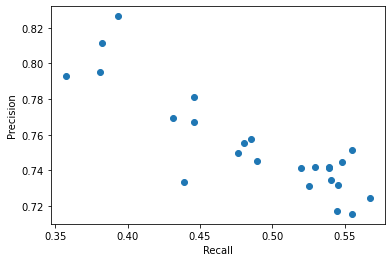

In [51]:
from sklearn.preprocessing import StandardScaler

# WARNING: YOU SHOULD ONLY HAVE TO WRITE CODE IN THE PART BELOW THAT SAYS "TODO"
kf = KFold(n_splits=5, random_state=95865, shuffle=True)
num_trees_choices = [50, 100, 150, 200]
max_depth_choices = [2, 3, 4, 5, 6, 7]
hyperparameter_choices = [(num_trees, max_depth)
                          for num_trees in num_trees_choices
                          for max_depth in max_depth_choices]
rf_cross_validation_precision_scores = []
rf_cross_validation_recall_scores = []

for num_trees, max_depth in hyperparameter_choices:
    # --------------------------------------------------------------------------
    # TODO: WRITE YOUR CODE HERE
    #
    
    
    fold_precision_scores = []
    fold_recall_scores = []
    for train_indices, val_indices in kf.split(diabetes_X_train):
        fold_X_train = diabetes_X_train[train_indices]
        fold_y_train = diabetes_y_train[train_indices]
        fold_X_val = diabetes_X_train[val_indices]
        fold_y_val = diabetes_y_train[val_indices]
        
        fold_scaler = StandardScaler()
        fold_X_train_standardized = fold_scaler.fit_transform(fold_X_train)
        fold_classifier = RandomForestClassifier(n_estimators=num_trees, max_depth=max_depth, random_state=95865)
        fold_classifier.fit(fold_X_train_standardized, fold_y_train)
        fold_y_val_predicted = fold_classifier.predict(fold_scaler.transform(fold_X_val))
        
        fold_true_pred_mask = (fold_y_val_predicted == 1)
        if fold_true_pred_mask.sum() > 0:
            fold_precision = (fold_y_val[fold_true_pred_mask] == 1).mean()
        else:
            # corner case to avoid division by 0
            fold_precision = 0.
        
        fold_recall_mask = (fold_y_val == 1)
        if fold_recall_mask.sum() > 0:
            fold_recall = (fold_y_val_predicted[fold_recall_mask] == 1).mean()
        else:
            # corner case to avoid division by 0
            fold_recall = 0.
        
        fold_precision_scores.append(fold_precision)
        fold_recall_scores.append(fold_recall)
    cross_val_precision = np.mean(fold_precision_scores)
    cross_val_recall = np.mean(fold_recall_scores)
    
    #
    # END OF YOUR CODE
    # --------------------------------------------------------------------------
    
    print('num_trees: %d' % num_trees,
          'max_depth: %d' % max_depth,
          'Precision: %5.3f' % cross_val_precision,
          'Recall: %5.3f' % cross_val_recall)
    rf_cross_validation_precision_scores.append(cross_val_precision)
    rf_cross_validation_recall_scores.append(cross_val_recall)

plt.scatter(rf_cross_validation_recall_scores,
            rf_cross_validation_precision_scores)
plt.xlabel('Recall')
plt.ylabel('Precision')

Using the precision-recall plot above, suppose that for our clinical application, we want at least a *true positive rate* of 60%. Under this constraint, what is the largest precision that we could approximately be able to achieve according to our cross validation results? Which value of hyperparameters (among the ones we tried in cross validation) does this roughly correspond to?

**Solution**: Among the hyperparameter settings tested for random forests, none achieves recall of at least 60%. Thus, we cannot say what precision is possible beyond the trivial lower bound of 0%.

**Important observation**: Your answer to the above question should make it clear that using training data and a precision-recall curve, we can actually pick a hyperparameter based on some application-specific constraint. The hyperparameter chosen can then be used for test data!